In [1]:
%pip install git+https://github.com/gbdrt/mu-ppl

  Cloning https://github.com/gbdrt/mu-ppl to /private/var/folders/xb/f8ptrt8j3kjdy_3q99ty7qrr0000gn/T/pip-req-build-xxpftaia
  Running command git clone --filter=blob:none --quiet https://github.com/gbdrt/mu-ppl /private/var/folders/xb/f8ptrt8j3kjdy_3q99ty7qrr0000gn/T/pip-req-build-xxpftaia
  Resolved https://github.com/gbdrt/mu-ppl to commit 898115aa0222f7808390ae0d34f297c020dbed07
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
from mu_ppl import *

# Introduction: Probabilistic Programming with mu-PPL

Let's start with simple a simple model adapted from [WebPPL](https://dippl.org/chapters/02-webppl.html) to introduce probabilistic programming in mu-ppl.

## Random execution with `sample`

A probabilistic model is a classic Python function.
The probabilistic operator `sample` draws a sample from a distribution which yields non-deterministic behavior.
For instance, the following model draws samples from three fair coins (`Bernoulli(0.5)`) and returns the sum of the samples.

In [3]:
def funny_bernoulli() -> int:
    a = sample(Bernoulli(0.5), name="a")
    b = sample(Bernoulli(0.5), name="b")
    c = sample(Bernoulli(0.5), name="c")
    return a + b + c

We can already execute the model to get a list of random samples.

In [4]:
[ funny_bernoulli() for _ in range(10) ]

[2, 1, 1, 2, 2, 1, 3, 2, 2, 1]

## Computing a distribution with `Infer`

The `infer` operator is used to compute the distribution describes by a model.
Following [Pyro](https://pyro.ai/), in mu-ppl we use _context managers_ to implement different inference algorithms.

Our model, only use finite discrete support distribution.
We can enumerate all possible execution to compute the distribution.

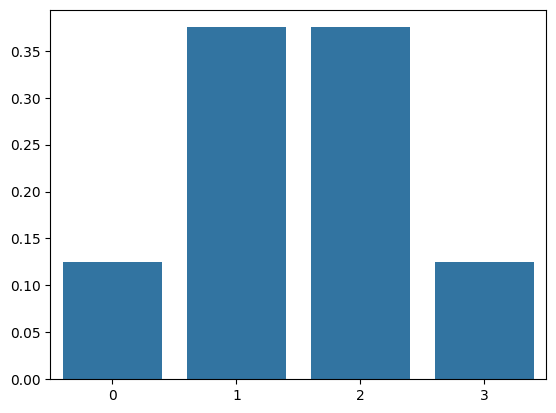

In [5]:
with Enumeration():
    dist: Categorical[float] = infer(funny_bernoulli) # type: ignore
    viz(dist)

**Remark:** In the model definition, each `sample` operator takes an optional argument `name` which specify a _unique_ name for each sample site.
This argument is required to run some inference algorithm.
In the enumation algorithm we use the names to compute the execution paths to be explored.

## Conditionning the model with `assume`

We can also make assumptions that must always hold.
For instance, the following model conditions `funny_bernoulli` with the assumption `assume(a == 1 or b == 1)`.
This new model cannot produce samples where both `a` and `b` are `0`.

In [6]:
def funny_bernoulli() -> int:
    a = sample(Bernoulli(0.5), name="a")
    b = sample(Bernoulli(0.5), name="b")
    c = sample(Bernoulli(0.5), name="c")
    assume(a == 1 or b == 1)
    return a + b + c

The `assume` operator "skews" the distribution.

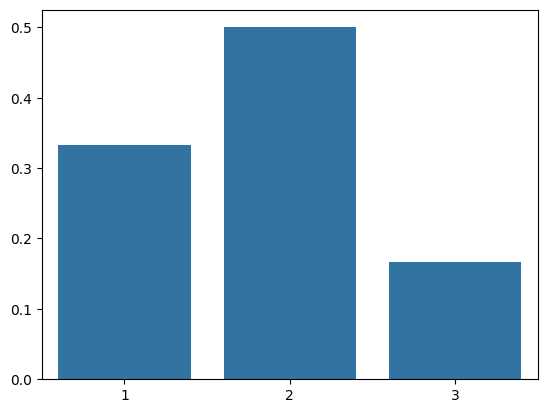

In [7]:
with Enumeration():
    dist: Categorical[float] = infer(funny_bernoulli)  # type: ignore
    viz(dist)


## Soft conditionning with `factor`

The `assume` operator performs _hard conditionning_ declaring an assertion that must hold for all valid execution.
An alternative is to rely on _soft conditionning_ which associates a weigth to each execution.

For instance, the following programs compute the sum of two dice.

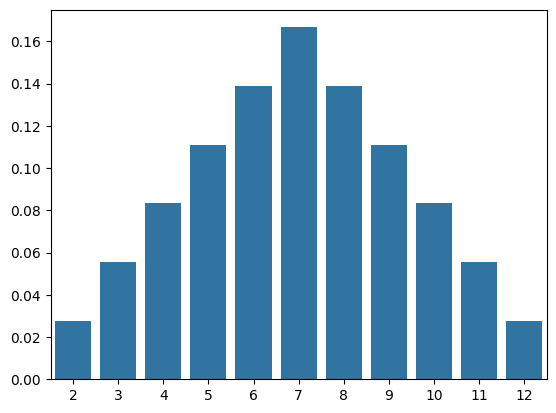

In [8]:
def dice() -> int:
    a = sample(RandInt(1, 6), name="a")
    b = sample(RandInt(1, 6), name="b")
    return a + b

with Enumeration():
    dist: Categorical[float] = infer(dice)  # type: ignore
    viz(dist)

We can modify the model to sligthly favor executions where the two dice return different values.
Again the resulting distribution is skewed.

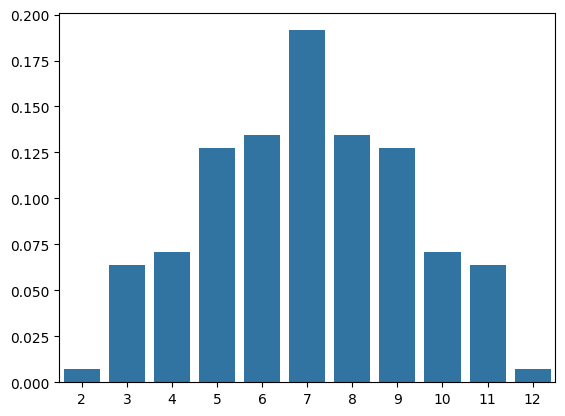

In [9]:
def dice() -> int:
    a = sample(RandInt(1, 6), name="a")
    b = sample(RandInt(1, 6), name="b")
    factor(1 if a != b else -0.5)
    return a + b

with Enumeration():
    dist: Categorical[float] = infer(dice)  # type: ignore
    viz(dist)